# Bangkit Final Project BDG-1D

Created by :
- Aji Wira Sumbaga (ajisumbaga7@gmail.com)
- Bayu Arif Budiman (bayuarifbudiman@gmail.com)
- Hasan Mustopa (hasanmust.hm@gmail.com)

This notebook contains the process of generating improved model :
1. Data Preparation
2. Data Preprocessing
3. Build The Model
4. Training The Model
5. First Evaluation of the Model
6. Fine Tuning
7. Second Evaluation of the Model
8. Saving the model (.tflite and .h5)

We also provided the additional feature to our android deployment app called Grad-CAM, Grad-CAM stands for Gradient Weighted Class Activation Mapping. This features could shows us the better understanding of an x-ray image classification. The code will be attached in the end of notebook.

In [1]:
# import dependencies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

### 1. Data Preparation
in this section we will load the data

In [2]:
metadata = pd.read_csv('Chest_xray_Corona_Metadata.csv')
summary = pd.read_csv('Chest_xray_Corona_dataset_Summary.csv')
train_dir = "Coronahack-Chest-XRay-Dataset/train"
test_dir = "Coronahack-Chest-XRay-Dataset/test"

In [3]:
summary

,Unnamed: 0,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,0,Normal,NaN,NaN,1576
1,1,Pnemonia,Stress-Smoking,ARDS,2
2,2,Pnemonia,Virus,NaN,1493
3,3,Pnemonia,Virus,COVID-19,58
4,4,Pnemonia,Virus,SARS,4
5,5,Pnemonia,bacteria,NaN,2772
6,6,Pnemonia,bacteria,Streptococcus,5


In [4]:
metadata.head(5)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


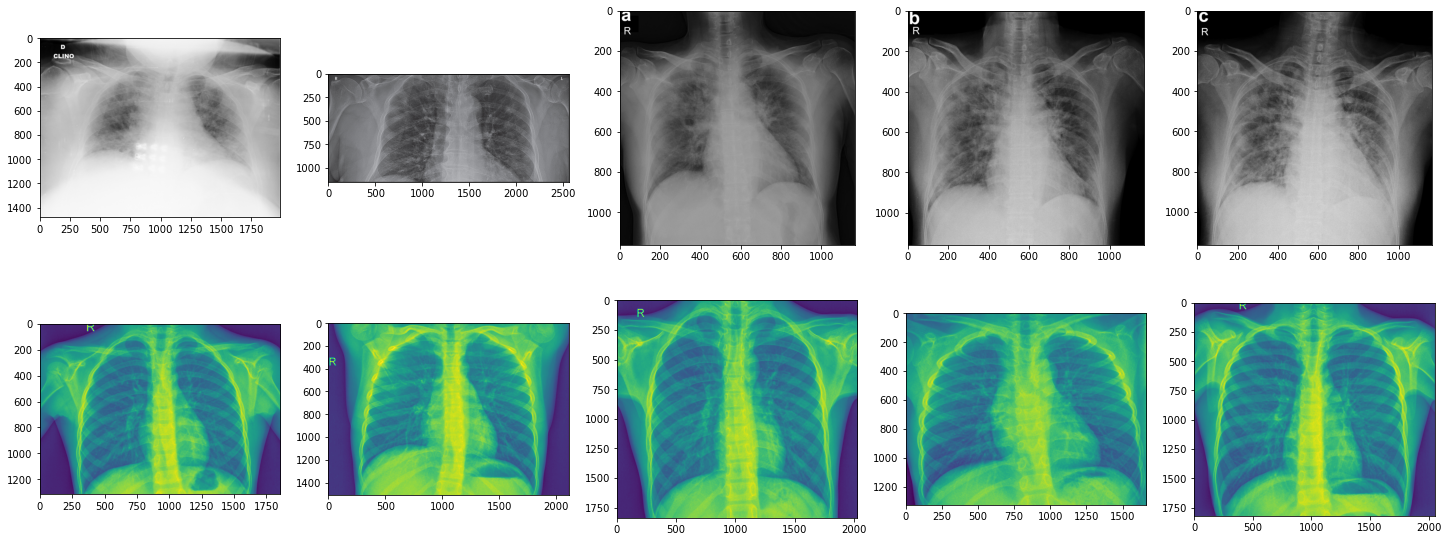

In [5]:
import os
import matplotlib.image as mpig

# extract filename from train and test folder
train_fname = os.listdir(train_dir)
test_fname = os.listdir(test_dir)

# See few sample from data train and test
plt.gcf().set_size_inches(25,25)
train_img = [os.path.join(train_dir, files) for files in train_fname[:5]]
test_img = [os.path.join(test_dir, files) for files in test_fname[:5]]
for i, image in enumerate(train_img+test_img):
  plt.subplot(5,5,1+i)
  img = mpig.imread(image)
  plt.imshow(img)

### 2. Data Preprocessing
In this section, we will prepare the train, validation, and test data.
Also found that the dataset is imbalanced, below is the procedure to handle the imbalanced dataset.
Beside of image augmentation, we apply the Contrast Limited Adaptive Histogram Equalization (CLAHE) to the input image, in order to show its features clearly so the model can calculate and process them easier.

In [6]:
#split into train and test dataset

train_data = metadata[metadata.Dataset_type =='TRAIN']
test_data  = metadata[metadata.Dataset_type == 'TEST']

In [7]:
balanced_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') & 
                               (train_data['Label_2_Virus_category'] == 'COVID-19'))]

balanced_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in balanced_data['Label']]

balanced_data_subset_normal = balanced_data[balanced_data['target'] == 'negative']
balanced_data_subset_covid = balanced_data[balanced_data['target'] == 'positive']
balanced_data_frac_normal = balanced_data_subset_normal.sample(frac=(1/5))

balanced_data_concat = pd.concat([balanced_data_frac_normal, balanced_data_subset_covid], axis=0)
balanced_data_concat = shuffle(balanced_data_concat, random_state=0)
balanced_data_train = balanced_data_concat[:240]
balanced_data_validation = balanced_data_concat[240:]

print(f"Balanced train data shape {balanced_data_train.shape}")
print(f"Balanced validation data shape {balanced_data_validation.shape}")

Balanced train data shape (240, 7)
Balanced validation data shape (86, 7)


C:\Users\Admin\anaconda3\envs\dsta\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [8]:
test_data = test_data[(test_data['Label'] == 'Normal') | 
                              ((test_data['Label'] == 'Pnemonia') & 
                               (test_data['Label_2_Virus_category'] == 'COVID-19'))]

test_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in test_data['Label']]

print(f"Test data shape {test_data.shape}")

Test data shape (234, 7)


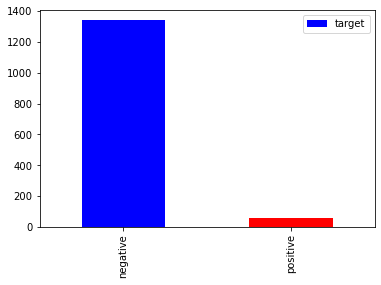

In [9]:
balanced_data.target.value_counts().plot(kind='bar', color=['b','r'])
plt.legend()

Training -> class distribution : 
 negative    0.845833
positive    0.154167
Name: target, dtype: float64


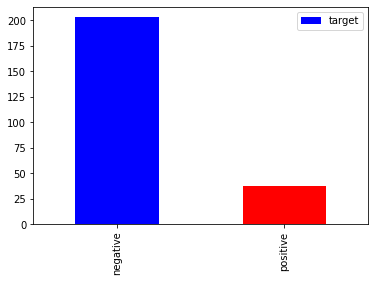

In [10]:
balanced_data_train.target.value_counts().plot(kind='bar', color=['b','r'])
plt.legend()
print('Training -> class distribution : \n', balanced_data_train.target.value_counts(normalize=True))

Validation -> class distribution : 
 negative    0.755814
positive    0.244186
Name: target, dtype: float64


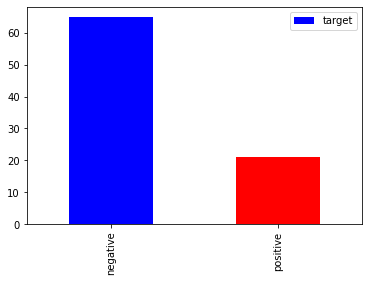

In [11]:
balanced_data_validation.target.value_counts().plot(kind='bar', color=['b','r'])
plt.legend()
print('Validation -> class distribution : \n', balanced_data_validation.target.value_counts(normalize=True))

Validation -> class distribution : 
 negative    1.0
Name: target, dtype: float64


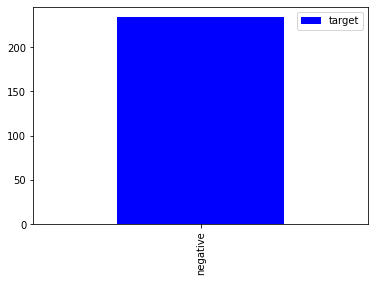

In [12]:
test_data.target.value_counts().plot(kind='bar', color=['b','r'])
plt.legend()
print('Validation -> class distribution : \n', test_data.target.value_counts(normalize=True))

In [13]:
from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpig
import cv2

#declare the CLAHE function
def CLAHE(img):
    data = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
    data = exposure.equalize_adapthist(data, clip_limit=0.5)
    data = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_32F)
    return data

<Figure size 432x288 with 0 Axes>

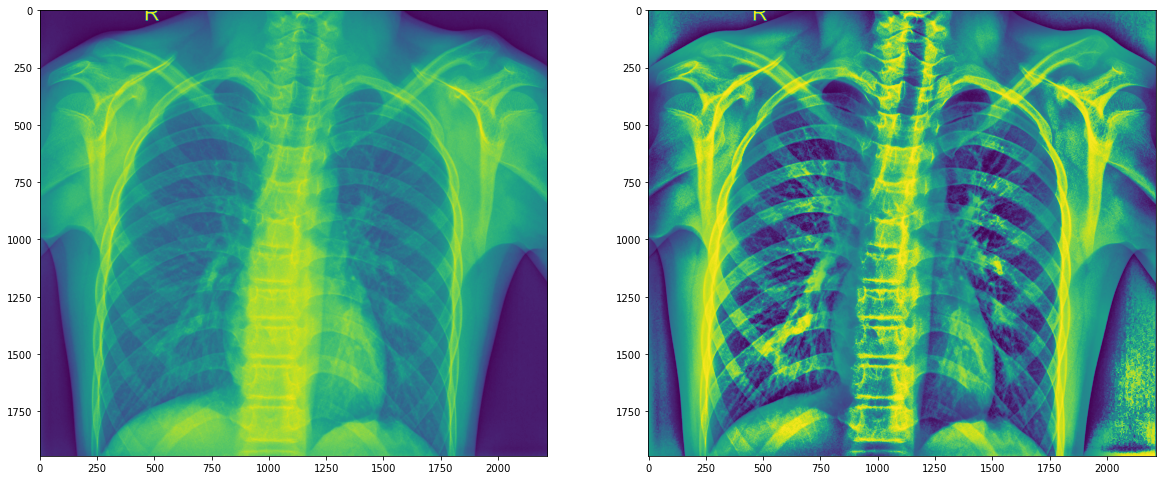

In [14]:
#show CLAHE calculation
img_raw = mpig.imread('Coronahack-Chest-XRay-Dataset/test/IM-0011-0001-0002.jpeg')
img = img_raw.astype(np.float32)
img = CLAHE(img)
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20, 20)) 
axarr[0].imshow(img_raw)
axarr[1].imshow(img)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#image data generator
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=[0.9, 1.25],
    brightness_range=[0.5, 1.5],
    preprocessing_function=CLAHE)

test_image_generator = ImageDataGenerator(
    rescale=1./255
)

balanced_train_generator = train_image_generator.flow_from_dataframe(
    dataframe=balanced_data_train,
    directory=train_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    shuffle=True,
    class_mode='categorical'
)

balanced_validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=balanced_data_validation,
    directory=train_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    shuffle=True,
    class_mode='categorical'
)

test_gen = test_image_generator.flow_from_dataframe(
    dataframe= test_data,
    directory = test_dir,
    x_col = 'X_ray_image_name',
    y_col = 'target',
    target_size=(224, 224),
    batch_size=8,
    seed=2020,
    shuffle=True,
    class_mode=None  
)

Found 240 validated image filenames belonging to 2 classes.
Found 86 validated image filenames belonging to 2 classes.
Found 234 validated image filenames.


### 3. Build The Model

In order to build our model, we used the transfer learning method. Transfer learning allows us to achieve high performance [[1]](https://link.springer.com/article/10.1186/s40537-019-0276-2#Sec26). We build two model here, using Resnet50 and Xception as base model in transfer learning method. Based on their performance, we decide to use the second model (Xception). Xception is also recognized as best model to do medical image classification [[2]](https://www.researchgate.net/publication/340878513_A_Transfer_Learning_Method_for_Pneumonia_Classification_and_Visualization).

Source : 
1. Yadav, S.S., Jadhav, S.M. Deep convolutional neural network based medical image classification for disease diagnosis. J Big Data 6, 113 (2019).
2. Luján-García, Juan & Yáñez-Márquez, Cornelio & Villuendas-Rey, Yenny & Camacho, Oscar. (2020). A Transfer Learning Method for Pneumonia Classification and Visualization. Applied Sciences. 10. 2908. 10.3390/app10082908.

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import *

#callbacks
tf.keras.backend.clear_session()
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>0.998):
                print("\nReached 99.8% accuracy so cancelling training!")
                self.model.stop_training = True

from tensorflow.keras.callbacks import LearningRateScheduler              
def scheduler(epoch):
    if epoch < 12:
      return 0.001
    else:
      print("Learning rate reduced to :", 0.001 * np.exp(0.5 * (5 - epoch)))
      return 0.001 * np.exp(0.5 * (5 - epoch))

lr_callbacks = LearningRateScheduler(scheduler)
acc_callbacks = myCallback()

#metrics
metrics = [
    'accuracy',
    Precision(name='precision'),
    TruePositives(name='tp'),
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn')
]

In [17]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

#build first model using Resnet50 as base Model
#load the Resnet50 network, ensuring the head FC layer sets are leftoff
baseModel = ResNet50(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(name="avg_pool2d",pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu",name="first_dense")(headModel)
headModel = Dropout(0.5,name="dropout")(headModel)
headModel = Dense(2, activation="softmax",name="second_dense")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

#build second model using Xception as base model
#load the Xception network, ensuring the head FC layer sets are leftoff
baseModel2 = Xception(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the the base model
headModel2 = baseModel2.output
headModel2 = AveragePooling2D(name="avg_pool2d",pool_size=(4, 4))(headModel2)
headModel2 = Flatten(name="flatten")(headModel2)
headModel2 = Dense(64, activation="relu",name="first_dense")(headModel2)
headModel2 = Dropout(0.5,name="dropout")(headModel2)
headModel2 = Dense(2, activation="softmax",name="second_dense")(headModel2)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model2 = Model(inputs=baseModel2.input, outputs=headModel2)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel2.layers:
    layer.trainable = False

model2.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=metrics)

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

### 4. Training The Model

In [ ]:
history1 = model.fit(x=balanced_train_generator,
                    validation_data=balanced_validation_generator,
                    steps_per_epoch=len(balanced_data_train)//8,
                    epochs=20,
                    validation_steps=len(balanced_data_validation)//8,
                    verbose=1,
                    callbacks=[lr_callbacks, acc_callbacks])

In [19]:
history2 = model2.fit(x=balanced_train_generator,
                    validation_data=balanced_validation_generator,
                    steps_per_epoch=len(balanced_data_train)//8,
                    epochs=20,
                    validation_steps=len(balanced_data_validation)//8,
                    verbose=1,
                    callbacks=[lr_callbacks, acc_callbacks])

C:\Users\Admin\anaconda3\envs\dsta\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Admin\anaconda3\envs\dsta\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
30/30 [==============================] - 69s 2s/step - loss: 0.5312 - accuracy: 0.8292 - precision: 0.8292 - tp: 199.0000 - fp: 41.0000 - tn: 199.0000 - fn: 41.0000 - val_loss: 0.3137 - val_accuracy: 0.8625 - val_precision: 0.8625 - val_tp: 69.0000 - val_fp: 11.0000 - val_tn: 69.0000 - val_fn: 11.0000 - lr: 0.0010
Epoch 2/20
30/30 [==============================] - 72s 2s/step - loss: 0.2188 - accuracy: 0.9167 - precision: 0.9167 - tp: 220.0000 - fp: 20.0000 - tn: 220.0000 - fn: 20.0000 - val_loss: 0.1874 - val_accuracy: 0.9125 - val_precision: 0.9125 - val_tp: 73.0000 - val_fp: 7.0000 - val_tn: 73.0000 - val_fn: 7.0000 - lr: 0.0010
Epoch 3/20
30/30 [==============================] - 72s 2s/step - loss: 0.1626 - accuracy: 0.9417 - precision: 0.9417 - tp: 226.0000 - fp: 14.0000 - tn: 226.0000 - fn: 14.0000 - val_loss: 0.1734 - val_accuracy: 0.9125 - val_precision: 0.9125 - val_tp: 73.0000 - val_fp: 7.0000 - val_tn: 73.0000 - val_fn: 7.0000 - lr: 0.0010
Epoch 4/20
30/30 [=====

### 5. First Evaluation of the Model

Since the dataset is imbalanced, we can not use train accuracy as the reference. So we have to use precision, recall, and f-measure [[source]](https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/). Below is the function to calculate our model performance.

In [20]:
def plot_loss_acc(history):
    
    plt.figure(figsize=(14,6))
    plt.subplot2grid((1,2),(0,0))
    plt.plot(history.history['loss'], label = ('Train Loss'))
    plt.plot(history.history['val_loss'], label ='Validation Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.subplot2grid((1,2),(0,1))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label ='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    
    plt.show()

In [21]:
def classification_report(history):
    #Train report
    TP = history.history['tp'][-1] #True Positive
    FP = history.history['fp'][-1] #False Positif
    TN = history.history['tn'][-1] #True Negative
    FN = history.history['fn'][-1] #False Negatife

    confusion_matrix = np.matrix([[TP,FP],[FN,TN]])
    recall = 100*TP/(TP+FN)
    precision = 100*TP/(TP+FP)
    acc = history.history['accuracy'][-1]
    F_Measure = (2 * precision * recall) / (precision + recall)
    
    #Validation Report
    vTP = history.history['val_tp'][-1] #True Positive
    vFP = history.history['val_fp'][-1] #False Positif
    vTN = history.history['val_tn'][-1] #True Negative
    vFN = history.history['val_fn'][-1] #False Negatife

    val_confusion_matrix = np.matrix([[vTP,vFP],[vFN,vTN]])
    val_recall = 100*vTP/(vTP+vFN)
    val_precision = 100*vTP/(vTP+vFP)
    val_acc = history.history['val_accuracy'][-1]
    val_F_Measure = (2 * val_precision * val_recall) / (val_precision + val_recall)
    
    print('Training Report : \n')
    print('Confusion Matrix : \n', confusion_matrix,'\n')
    print('Recall : ', recall)
    print("Precision : ",precision)
    print('Accuracy : ', 100*acc)
    print('F-Measure : ', F_Measure)
    print('')
    print('Validation Report : \n')
    print('Confusion Matrix : \n', val_confusion_matrix,'\n')
    print('Recall : ', val_recall)
    print("Precision : ",val_precision)
    print('Accuracy : ', 100*val_acc)
    print('F-Measure : ', val_F_Measure)

In [ ]:
plot_loss_acc(history1)
classification_report(history1)

In [ ]:
# model evaluation
result = model.evaluate(test_gen, steps=len(test_data)//8)

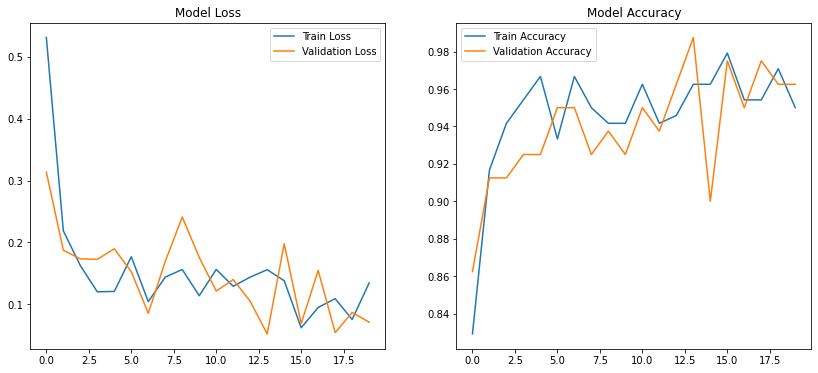

Training Report : 

Confusion Matrix : 
 [[228.  12.]
 [ 12. 228.]] 

Recall :  95.0
Precision :  95.0
Accuracy :  94.9999988079071
F-Measure :  95.0

Validation Report : 

Confusion Matrix : 
 [[77.  3.]
 [ 3. 77.]] 

Recall :  96.25
Precision :  96.25
Accuracy :  96.24999761581421
F-Measure :  96.25


In [22]:
plot_loss_acc(history2)
classification_report(history2)

In [23]:
# model evaluation
result = model2.evaluate(test_gen, steps=len(test_data)//8)

29/29 [==============================] - 4s 128ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 0.0000e+00


### 6. Fine Tuning

   One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.
   
   In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning. 

We see the model2 (xception) has better performance than model1 (resnet50), so we decide to do fine tuning only on model2.

In [25]:
#change the layer's state to be trainable
baseModel2.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(baseModel2.layers))

Number of layers in the base model:  132


In [26]:
# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in baseModel2.layers[:fine_tune_at]:
  layer.trainable =  False

model2.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=metrics)

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [27]:
fine_tune_epochs = 15
total_epochs =  20 + fine_tune_epochs

history2_fine = model2.fit(x=balanced_train_generator,
                    validation_data=balanced_validation_generator,
                    steps_per_epoch=len(balanced_data_train)//8,
                    initial_epoch =  history2.epoch[-1],
                    epochs=total_epochs,
                    validation_steps=len(balanced_data_validation)//8,
                    verbose=1,
                    callbacks=[lr_callbacks, acc_callbacks])

Learning rate reduced to : 9.118819655545163e-07
Epoch 20/35
30/30 [==============================] - 58s 2s/step - loss: 0.3885 - accuracy: 0.8500 - precision: 0.8500 - tp: 204.0000 - fp: 36.0000 - tn: 204.0000 - fn: 36.0000 - val_loss: 0.1465 - val_accuracy: 0.9250 - val_precision: 0.9250 - val_tp: 74.0000 - val_fp: 6.0000 - val_tn: 74.0000 - val_fn: 6.0000 - lr: 9.1188e-07
Learning rate reduced to : 5.530843701478336e-07
Epoch 21/35
30/30 [==============================] - 58s 2s/step - loss: 0.3252 - accuracy: 0.8833 - precision: 0.8833 - tp: 212.0000 - fp: 28.0000 - tn: 212.0000 - fn: 28.0000 - val_loss: 0.0766 - val_accuracy: 0.9750 - val_precision: 0.9750 - val_tp: 78.0000 - val_fp: 2.0000 - val_tn: 78.0000 - val_fn: 2.0000 - lr: 5.5308e-07
Learning rate reduced to : 3.3546262790251187e-07
Epoch 22/35
30/30 [==============================] - 60s 2s/step - loss: 0.3504 - accuracy: 0.8708 - precision: 0.8708 - tp: 209.0000 - fp: 31.0000 - tn: 209.0000 - fn: 31.0000 - val_loss: 0.1

### 7. Second Evaluation of the Model

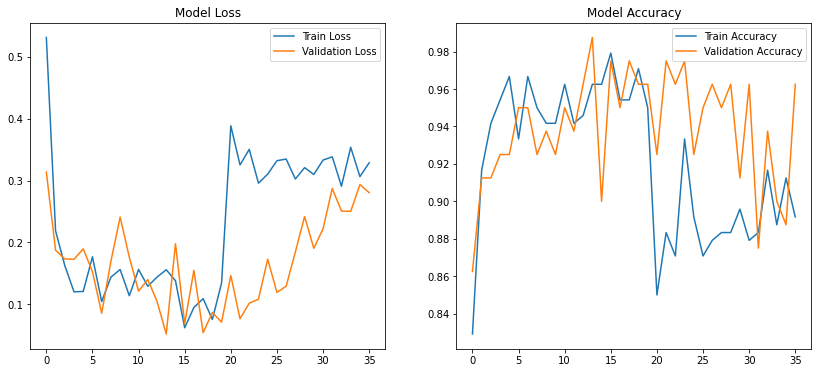

Training Report : 

Confusion Matrix : 
 [[214.  26.]
 [ 26. 214.]] 

Recall :  89.16666666666667
Precision :  89.16666666666667
Accuracy :  89.16666507720947
F-Measure :  89.16666666666667

Validation Report : 

Confusion Matrix : 
 [[77.  3.]
 [ 3. 77.]] 

Recall :  96.25
Precision :  96.25
Accuracy :  96.24999761581421
F-Measure :  96.25


In [28]:
acc = history2.history['accuracy'] + history2_fine.history['accuracy']
val_acc = history2.history['val_accuracy'] + history2_fine.history['val_accuracy']

loss = history2.history['loss'] + history2_fine.history['loss']
val_loss = history2.history['val_loss'] + history2_fine.history['val_loss']

plt.figure(figsize=(14,6))
plt.subplot2grid((1,2),(0,0))
plt.plot(loss, label = ('Train Loss'))
plt.plot(val_loss, label ='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot2grid((1,2),(0,1))
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label ='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.show()

classification_report(history2_fine)

In [29]:
# model evaluation
result = model2.evaluate(test_gen, steps=len(test_data)//8)

29/29 [==============================] - 8s 284ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 0.0000e+00


### 8. Saving the model (pb , h5, and .tflite)

In [24]:
#for now, we save the second model without fine tuning

#.h5
model2.save('modelxcp-20ep-c0,5-u8.h5')

#.tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()
open("modelxcp-20ep-c0,5-u8.tflite", "wb").write(tflite_quantized_model)

21070496

## Grad-CAM (Gradient Weighted Class Activation Mapping)

How to obtain a class activation heatmap for an image classification model. The technique uses class-specific gradient information to localize important regions. These methods help better understand CNN-based models. We could evaluate our visual explanations by measuring their ability to discriminate between classes, to inspire trust in humans, and their correlation with occlusion maps.

Grad-CAM does give an idea which part of the image is forcing the classification.
Convolution layer is where the model extracts features/information from the input image before it is processed into a fully connected layer. This technique is like taking the output of the last convolution layer (keep in mind, since we extract the features from the input image, it can be concluded that the output of this convolution layer is the region in the input image where our model focuses on classification). Then we can create a superimposed image by superimposing the CAM image with the original image input.

Source :
1. Ramprasaath R. Selvaraju. Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization. IJCV. 2019 [[1]](https://arxiv.org/pdf/1610.02391.pdf)
2. Ramprasaath R. Selvaraju. Grad-CAM: Why did you say that? ArXiv. 2016 [[2]](https://arxiv.org/pdf/1611.07450.pdf)
3. Morbidelli, P., Carrera, D., Rossi, B., Fragneto, P., & Boracchi, G. (2020). Augmented Grad-CAM: Heat-Maps Super Resolution Through Augmentation. ICASSP 2020 [[3]](https://ieeexplore.ieee.org/document/9054416)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_path = 'model.h5'
model = tf.keras.models.load_model(model_path)
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool2d",
    "flatten",
    "first_dense",
    "dropout",
    "second_dense"
]

# The local path to our target image
img_path = 'Coronahack-Chest-XRay-Dataset/test/person1640_virus_2839.jpeg'

display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.3 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "covid_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))